In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import dataset as dd # custom dataset class
import unet

# so that when you change an imported file, it changes in the notebook
%load_ext autoreload 
%autoreload 2
%matplotlib notebook

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

im_ref, im_us = dd.get_dataset(1)
X_train, y_train = (im_us,  im_ref)

im_ref_test, im_us_test = dd.get_dataset(1)
X_test, y_test = (im_us_test, im_ref_test)



In [2]:
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

('Training data shape: ', (320, 320, 256, 8))
('Training labels shape: ', (320, 320, 256, 1))
('Test data shape: ', (320, 320, 256, 8))
('Test labels shape: ', (320, 320, 256, 1))


In [8]:
from unetblocks import res_block, gen_conv_relu, gen_conv_bn_relu

input_shape = X_train.shape[1:]
inputs = tf.keras.layers.Input(shape=input_shape)
f16 = {'filters': 16, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same'}
f32 = f16.copy()
f32['filters'] = 32
f64 = f32.copy()
f64['filters'] = 64
f128 = f64.copy()
f128['filters'] = 128

gen_fn = gen_conv_relu

res_out = res_block(gen_fn(**f16), gen_fn(**f16))(inputs, 
                                                      resblocks=[res_block(gen_fn(**f32), gen_fn(**f32)),
                                                                 res_block(gen_fn(**f64), gen_fn(**f64)),
                                                                         res_block(gen_fn(**f128))])
out = tf.keras.layers.Dense(1)(res_out)
model = tf.keras.models.Model(inputs=inputs, outputs=out)
## example from https://keras.io/callbacks/
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

history = LossHistory()
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='/home/pkllee/tmp/')

adam_optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1 = 0.9, beta_2=0.999, decay=0.01)

model.compile(optimizer=adam_optimizer, loss='mean_squared_error', metrics=['mse'])

In [9]:
model.fit(x=X_train, y=y_train, callbacks=[history, tb_callback], epochs=100)

Epoch 1/100
320/320 [==============================] - 8s 24ms/step - loss: 6.7918e-04 - mean_squared_error: 6.7918e-04
Epoch 2/100
320/320 [==============================] - 8s 24ms/step - loss: 2.2675e-04 - mean_squared_error: 2.2675e-04
Epoch 3/100
320/320 [==============================] - 7s 22ms/step - loss: 1.8477e-04 - mean_squared_error: 1.8477e-04
Epoch 4/100
320/320 [==============================] - 7s 21ms/step - loss: 1.6665e-04 - mean_squared_error: 1.6665e-04
Epoch 5/100
320/320 [==============================] - 7s 21ms/step - loss: 1.5847e-04 - mean_squared_error: 1.5847e-04
Epoch 6/100
320/320 [==============================] - 8s 24ms/step - loss: 1.5029e-04 - mean_squared_error: 1.5029e-04
Epoch 7/100
320/320 [==============================] - 7s 23ms/step - loss: 1.4250e-04 - mean_squared_error: 1.4250e-04
Epoch 8/100
320/320 [==============================] - 8s 24ms/step - loss: 1.3368e-04 - mean_squared_error: 1.3368e-04
Epoch 9/100
320/320 [===================

320/320 [==============================] - 7s 21ms/step - loss: 5.2644e-05 - mean_squared_error: 5.2644e-05
Epoch 69/100
320/320 [==============================] - 7s 21ms/step - loss: 5.2624e-05 - mean_squared_error: 5.2624e-05
Epoch 70/100
320/320 [==============================] - 7s 20ms/step - loss: 5.2260e-05 - mean_squared_error: 5.2260e-05
Epoch 71/100
320/320 [==============================] - 7s 20ms/step - loss: 5.2059e-05 - mean_squared_error: 5.2059e-05
Epoch 72/100
320/320 [==============================] - 7s 23ms/step - loss: 5.1697e-05 - mean_squared_error: 5.1697e-05
Epoch 73/100
320/320 [==============================] - 8s 25ms/step - loss: 5.1410e-05 - mean_squared_error: 5.1410e-05
Epoch 74/100
320/320 [==============================] - 8s 24ms/step - loss: 5.1179e-05 - mean_squared_error: 5.1179e-05
Epoch 75/100
320/320 [==============================] - 8s 24ms/step - loss: 5.0892e-05 - mean_squared_error: 5.0892e-05
Epoch 76/100
320/320 [=======================

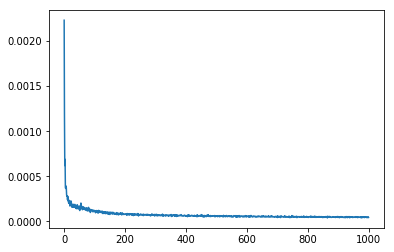

In [10]:
plt.plot(history.losses)
plt.show()

In [13]:
def sos(im, axis):
    return np.sqrt(np.sum(np.power(im, 2), axis=axis))

pred = model.predict(X_test)
to_show_ref = im_ref_test
to_show_us = im_us_test

mean_squared_error = sos(np.rave(pred - to_show_ref), axis=0)
print(mean_squared_error)

AttributeError: 'module' object has no attribute 'flatten'

In [ ]:
slice_to_show = 100


im1 = to_show_ref[slice_to_show, :, :, 0]
im2 = sos(to_show_us[slice_to_show, :, :, :], axis=2)
im3 = pred[slice_to_show, :, :, 0]


fig = plt.figure(figsize=(10, 10))
plt.imshow(np.hstack((im3, im1, im2)), cmap='gray')
plt.title('pred | ref | us')
plt.axis('off')
plt.show()

fig = plt.figure(figsize=(5, 5))
plt.imshow(abs(im3 - im1), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()